# 8.1. Deep Convolutional Neural Networks (AlexNet)

In [1]:
!pip install d2l

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

8.1.2.3. Capacity Control and Preprocessing

In [3]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [4]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

8.1.3. Training

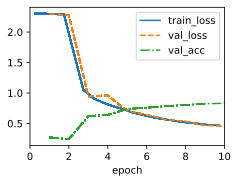

In [5]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

# 8.2. Networks Using Blocks (VGG)

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

8.2.1. VGG Blocks

In [7]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

8.2.2. VGG Network

In [8]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [9]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


8.2.3. Training

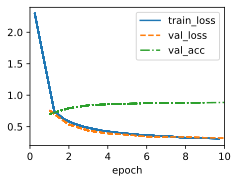

In [10]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.3. Network in Network (NiN)

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

8.3.1. NiN Blocks

In [12]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

8.3.2. NiN Model

In [13]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

In [14]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


8.3.3. Training

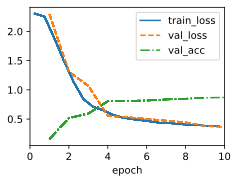

In [15]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.4. Multi-Branch Networks (GoogLeNet)

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

8.4.1. Inception Blocks

In [17]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

8.4.2. GoogLeNet Model

In [18]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [19]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [20]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [21]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [22]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [23]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [24]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


8.4.3. Training

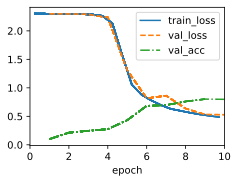

In [25]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.5. Batch Normalization

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

8.5.3. Implementation from Scratch

In [27]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [28]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

8.5.4. LeNet with Batch Normalization

In [29]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

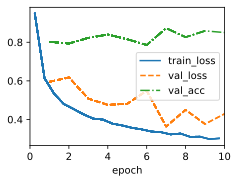

In [30]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [31]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.5586, 1.5998, 1.6328, 1.7797, 1.9429, 2.1449], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 1.6122,  0.1875, -1.2234,  1.4112,  1.1607,  0.9909], device='cuda:0',
        grad_fn=<ViewBackward0>))

8.5.5. Concise Implementation

In [32]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

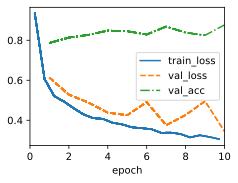

In [33]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# 8.6. Residual Networks (ResNet) and ResNeXt


In [34]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

8.6.2. Residual Blocks

In [35]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [36]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [37]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

8.6.3. ResNet Model

In [38]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [39]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [40]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [41]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


8.6.4. Training

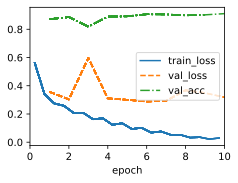

In [42]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

8.6.5. ResNeXt

In [43]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [44]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])

# 8.7. Densely Connected Networks (DenseNet)

In [45]:
import torch
from torch import nn
from d2l import torch as d2l

8.7.2. Dense Blocks¶

In [46]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [47]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [48]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

8.7.3. Transition Layers

In [49]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [50]:
blk = transition_block(10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

8.7.4. DenseNet Model

In [51]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [52]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

8.7.5. Training

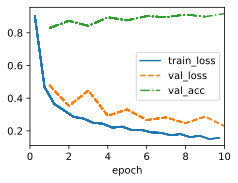

In [53]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# 8.8. Designing Convolution Network Architectures

In [54]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

8.8.1. The AnyNet Design Space

In [55]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

In [56]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

In [57]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

8.8.3. RegNet

In [58]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [59]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


8.8.4. Training

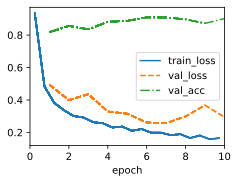

In [60]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# 8.1.5 Exercises

1. Following up on the discussion above, analyze the computational properties of AlexNet.

**a. Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?**

For AlexNet, the memory footprint consists of the parameters and activations in both the convolutional and fully connected layers.

Fully connected layers dominate memory, especially because they have far more parameters than convolutional layers.

**b. Calculate the computational cost for the convolutions and the fully connected layers.**

Fully Connected Layers: The computational cost in fully connected layers comes from matrix multiplication, which scales as:
Operations = Number of Input Neurons × Number of Output Neurons.

Which dominates?

In terms of FLOPs (floating point operations), convolutional layers usually dominate due to the larger number of operations required to process the spatial dimensions of the input data.

**c. How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?**

Memory factors such as bandwidth, latency, and size greatly influence the computational performance:

Read and Write Bandwidth: Affects the speed at which data is transferred between memory and compute units. Low bandwidth can bottleneck the computation, especially in convolutional layers that require multiple data transfers for feature maps.

Latency: Higher memory latency can slow down computation by increasing the time taken to fetch data. This becomes critical when dealing with small datasets or small batch sizes, as the overhead of data transfer can outpace computation.

Size: Insufficient memory (e.g., GPU VRAM) can force models to store intermediate data off-chip, which severely impacts performance.

For training, memory usage is more intensive due to the need to store intermediate gradients, whereas for inference, memory usage is lower since there's no need for gradient storage.

**2. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?**

As a chip designer, the trade-off between computation and memory bandwidth is key:

More Computation: A faster chip will require more power and might increase chip size due to additional processing units. You could optimize this by using specialized hardware like tensor cores (NVIDIA) for deep learning operations.

More Memory Bandwidth: Increasing memory bandwidth requires more pins and control logic, which increases chip size and power consumption. It’s often efficient to optimize the memory hierarchy by using local buffers (e.g., caches) to reduce memory access from external sources.

Optimization Strategies:

Using quantization to reduce memory usage and computational cost.
Balancing computation and memory access by using efficient dataflow architectures that minimize data movement.
Reducing the number of off-chip memory accesses by utilizing larger on-chip caches.

**3. Why do engineers no longer report performance benchmarks on AlexNet?**

AlexNet was a pioneering architecture, but its benchmarks are no longer commonly reported due to the rise of more efficient architectures like ResNet, EfficientNet, and MobileNet, which outperform AlexNet in terms of accuracy, speed, and resource efficiency.

These newer architectures are designed to reduce parameter count while maintaining accuracy, making them more suitable for modern computational tasks.

**4. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?**

Training AlexNet for more epochs generally improves performance, but:

LeNet: Being a simpler architecture, it converges faster and requires fewer epochs to achieve its best performance.
AlexNet: Its deeper architecture may take longer to converge but ultimately achieves higher accuracy, especially for complex datasets.
Differences arise due to the larger capacity of AlexNet, which helps it generalize better on larger datasets, while LeNet is more suited for simpler tasks like MNIST.

**AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.**

**a. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.**

Fashion-MNIST consists of low-resolution (28x28) images, making AlexNet overkill. The large convolutional filters and fully connected layers of AlexNet are better suited for higher-resolution images (like ImageNet's 224x224).

Simplification Strategy:

Reduce the number of convolutional layers.
Decrease the filter size and number of parameters.
Replace the fully connected layers with global average pooling to reduce parameter count.Changing the batch size affects:



**6. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.**

Changing the batch size affects:

Throughput: A larger batch size increases throughput (images/s) because modern hardware can process more data in parallel.
Accuracy: In some cases, larger batch sizes can lead to lower accuracy due to poorer generalization, but this can be mitigated with proper optimization techniques.
Memory: Larger batch sizes require more GPU memory, which could lead to memory overflows if VRAM is insufficient.
This will make training faster without sacrificing much accuracy.

**7. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?**

Applying Dropout and ReLU to LeNet-5 improves its performance by:

Dropout: Helps prevent overfitting by randomly deactivating neurons during training.
ReLU: Speeds up convergence by mitigating the vanishing gradient problem present with sigmoid or tanh activations.
Further improvement can be achieved by preprocessing the images to exploit invariances, such as using data augmentation techniques like rotation or flipping.

**8. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?**

To make AlexNet overfit:

- Remove Dropout layers or reduce data augmentation.
- Reduce the dataset size to make it easier for the model to memorize specific patterns in the training data.

This can lead to poor generalization, as the model becomes highly specialized in the training set and fails to perform well on unseen data.



# 8.2.5 Exercises

**1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory.**

**a. Compare the number of parameters needed for AlexNet and VGG.**

AlexNet: Approximately 60 million parameters.
The large number of parameters is mostly due to the fully connected layers, especially in the last three layers.

VGG-16: Approximately 138 million parameters.
VGG uses a simpler structure where most of the complexity comes from stacking small 3x3 convolutions, which results in more parameters, especially in the deeper layers.

Comparison:

VGG has significantly more parameters than AlexNet because VGG employs smaller convolution filters (3x3) but stacks more layers. This leads to more filters being applied to intermediate feature maps, increasing the parameter count. VGG’s fully connected layers also contribute heavily to the parameter explosion.

**b. Compare the number of floating point operations used in the convolutional layers and in the fully connected layers.**

Convolutional Layers:
Both networks are dominated by operations in the convolutional layers. For AlexNet, the convolutions use relatively large filters (11x11 in the first layer, 5x5 in others), leading to fewer layers but more operations per layer. VGG, on the other hand, uses smaller 3x3 filters but stacks more layers (13 convolutional layers in VGG-16).

VGG-16 has a significantly higher number of FLOPs compared to AlexNet because of the depth of the network, despite the smaller filter size.

Fully Connected Layers:
Both networks have large fully connected layers, but AlexNet relies heavily on its fully connected layers, which account for a substantial portion of the FLOPs. For VGG, although fully connected layers also consume a significant number of FLOPs, the total proportion is smaller relative to the FLOPs from the convolutional layers due to the deeper structure.

VGG has a higher total number of floating point operations, especially in the convolutional layers, due to its deeper architecture and the repeated use of small filters.

**c. How could you reduce the computational cost created by the fully connected layers?**

To reduce the computational cost in the fully connected layers, several strategies can be applied:

Replace Fully Connected Layers with Global Average Pooling,
Instead of large fully connected layers, use global average pooling after the convolutional layers. This reduces the number of parameters drastically and has been used in modern architectures like ResNet.

Parameter Reduction Techniques,
Techniques such as pruning and quantization can be applied to reduce the number of parameters and operations in fully connected layers. Pruning removes unimportant connections, while quantization reduces the precision of the parameters (e.g., from 32-bit floats to 16-bit floats).

Low-Rank Approximations,
Use low-rank approximations for the weight matrices in the fully connected layers to reduce their computational complexity.

**2. When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?**

VGG networks (e.g., VGG-16 and VGG-19) often list fewer layers than the total number of layers in the network. The reason for is,

The remaining three layers are the max-pooling layers, which are used for downsampling the feature maps after specific convolutional blocks. These layers do not have parameters (like convolutional or fully connected layers), so they might not be explicitly mentioned when describing the number of layers but are integral to the network's operation.

**3. Use Table 1 in the VGG paper (Simonyan and Zisserman, 2014) to construct other common models, such as VGG-16 or VGG-19.**

Using Table 1 from the VGG paper, the network architectures for VGG-16 and VGG-19 are constructed as follows:

VGG-16:

Convolutional Layers: 13

Fully Connected Layers: 3

Architecture:
- 2 Convolutional layers (64 filters) → Max-pooling
- 2 Convolutional layers (128 filters) → Max-pooling
- 3 Convolutional layers (256 filters) → Max-pooling
- 3 Convolutional layers (512 filters) → Max-pooling
- 3 Convolutional layers (512 filters) → Max-pooling
- 3 Fully Connected layers → Softmax

VGG-19:

Convolutional Layers: 16

Fully Connected Layers: 3

Architecture:

- 2 Convolutional layers (64 filters) → Max-pooling
- 2 Convolutional layers (128 filters) → Max-pooling
- 4 Convolutional layers (256 filters) → Max-pooling
- 4 Convolutional layers (512 filters) → Max-pooling
- 4 Convolutional layers (512 filters) → Max-pooling
-3 Fully Connected layers → Softmax

Both models are designed to progressively downsample the input while increasing the number of filters in each block to capture more complex features.

**5. Upsampling the resolution in Fashion-MNIST eight-fold from
 to dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network?**

 Upsampling Fashion-MNIST (28x28) images eight-fold to 224x224 (to match VGG’s typical input size) is wasteful because the dataset is low-resolution. Instead, you can modify the network to work with input resolutions of 56x56 or 84x84:

56x56 Input: You can retain the VGG architecture but modify the pooling and convolutional layers to work with this smaller input size. By reducing the resolution, you also reduce the number of operations and memory usage, making the model more efficient for low-resolution datasets.

84x84 Input: Similar approach, but the input has slightly more spatial resolution, allowing for more feature extraction before downsampling.

To maintain accuracy:

Add more nonlinearities: You could introduce additional layers with ReLU activations before each downsampling (max-pooling) stage to allow the network to learn more complex transformations before reducing the spatial dimensions.
Following the ideas from the VGG paper:

We can stack more 3x3 convolutions (with ReLU) before max-pooling to capture more spatial hierarchies in the smaller input resolution without significantly increasing the computational cost.
This approach should preserve accuracy while making the network more computationally efficient for low-resolution datasets like Fashion-MNIST.





# 8.3.5 Exercises

**1. Why are there two 1x1 convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?**

Two 1×1 convolutions increase nonlinearity and feature extraction.

- Three 1×1: More expressive but higher cost.
- One 1×1: Less powerful, possibly reducing accuracy.

**2. What changes if you replace the 1x1 convolutions by 3x3 convolutions?
- More computation cause 3×3 increases FLOPs and parameters.
- Better spatial feature extraction cause improves accuracy but at a higher cost.

**3. What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?**
Slower, more parameters, may improve accuracy but risks overfitting.

**4. Calculate the resource usage for NiN.**

**a. What is the number of parameters?**

NiN uses multiple 1×1 convolutions, which greatly reduce the parameter count compared to traditional fully connected layers. For example, a typical NiN architecture consists of several 1×1 convolutions with the form:

Convolutional layers: These layers have fewer parameters than layers with larger filters (e.g., 3x3 or 5x5). Each 1×1 convolution has Input Channels × Output Channels parameters.

Fully connected layers (if any): If fully connected layers are included (though in NiN, global average pooling is often used), these layers will dominate the number of parameters.


**b. What is the amount of computation?**

For NiN, the main computation comes from convolutions:

1×1 convolutions: These are efficient and lightweight, leading to fewer FLOPs.

3×3 or 5×5 convolutions (used earlier in the network): These contribute more to the FLOPs, but since NiN uses relatively few of these, the overall computation is lower compared to architectures like VGG.

**c. What is the amount of memory needed during training?**

Since NiN uses 1×1 convolutions and global average pooling, the memory usage is relatively lower than models like VGG that have larger fully connected layers and more complex convolutional layers.


**d. What is the amount of memory needed during prediction?**

During inference (prediction):

Only the activations and parameters need to be stored, with no need to store gradients.
Since NiN uses fewer parameters and no fully connected layers (if global average pooling is used), it’s relatively memory efficient during prediction compared to models like VGG or AlexNet.

**5. What are possible problems with reducing the 384 x 5 x 5 representation to a 10x5x5 representation in one step?**

Reducing a 384×5×5 representation directly to a 10×5×5 representation in one step could lead to several issues:

- Loss of information, Abruptly reducing the number of channels from 384 to 10 could result in the loss of important features, leading to degraded performance.
- Lack of feature hierarchy, Gradually reducing the number of channels helps the network build feature hierarchies at different levels of abstraction. Reducing in one step skips this process and may harm the model's ability to generalize.

A better approach is to reduce the number of channels in multiple stages to preserve the hierarchical feature representation.

**6. Use the structural design decisions in VGG that led to VGG-11, VGG-16, and VGG-19 to design a family of NiN-like networks.**


Using the structural design decisions of VGG (i.e., stacking small convolutions and progressively downsampling), we can design a NiN-like family of networks as follows:

a. NiN-11

Analogous to VGG-11:

Convolutions: Stack two 3×3 convolutions followed by a 1×1 convolution to form a NiN block.

Pooling: Apply max-pooling after each block to reduce spatial dimensions.
Global average pooling: Replace fully connected layers with global average pooling.

b. NiN-16

Analogous to VGG-16:

Deeper structure: Stack three 3×3 convolutions followed by 1×1 convolutions for more feature extraction.

More nonlinearities: Include ReLU activations after each convolution.

Pooling: Max-pooling after each block, with a deeper network providing better hierarchical feature extraction.

c. NiN-19

Analogous to VGG-19:

Deepest structure: Stack four 3×3 convolutions followed by 1×1 convolutions.

Global average pooling to replace fully connected layers.

Batch normalization: Add batch normalization layers between convolutions to help with regularization and training stability.

By designing these NiN-like networks with increasing depth (11, 16, 19 layers), we can create a family of architectures similar to the VGG design philosophy but with 1×1 convolutions for channel-wise feature extraction instead of fully connected layers, which keeps the models computationally efficient while still being expressive.




# 8.4.5 Exercises

**1. GoogLeNet was so successful that it went through a number of iterations, progressively improving speed and accuracy. Try to implement and run some of them. They include the following:**
1.	Add a batch normalization layer (Ioffe and Szegedy, 2015), as described later in Section 8.5.
2.	Make adjustments to the Inception block (width, choice and order of convolutions), as described in Szegedy et al. (2016).
3.	Use label smoothing for model regularization, as described in Szegedy et al. (2016).
4.	Make further adjustments to the Inception block by adding residual connection (Szegedy et al., 2017), as described later in Section 8.6.


In [ ]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),  # Batch normalization added
            nn.ReLU(True),
        )

        # 1x1 followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),  # Batch normalization added
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),  # Batch normalization added
            nn.ReLU(True),
        )

        # 1x1 followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),  # Batch normalization added
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),  # Batch normalization added
            nn.ReLU(True),
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),  # Batch normalization added
            nn.ReLU(True),
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)


In [ ]:
# Same as the previous InceptionModule, but with fewer filters for reduced computation
class InceptionV2Module(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionV2Module, self).__init__()

        # The 1x1 convolution acts as dimensionality reduction
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True),
        )

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True),
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True),
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)


In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        smooth_label = torch.full_like(pred, self.smoothing / (pred.size(1) - 1))
        smooth_label.scatter_(1, target.unsqueeze(1), confidence)
        loss = torch.mean(torch.sum(-smooth_label * torch.log_softmax(pred, dim=1), dim=1))
        return loss


In [ ]:
def forward(self, x):
    branch1x1 = self.branch1x1(x)
    branch3x3 = self.branch3x3(x)
    branch5x5 = self.branch5x5(x)
    branch_pool = self.branch_pool(x)

    outputs = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)
    return x + outputs  # Adding residual connection


**2. What is the minimum image size needed for GoogLeNet to work?**

The original GoogLeNet requires an input size of 224x224 pixels. This is due to the series of convolutional layers and pooling layers that progressively reduce spatial dimensions. Smaller images would need adjustments in the architecture.

**3.	Can you design a variant of GoogLeNet that works on Fashion-MNIST’s native resolution of 28×28 pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?**

To adapt GoogLeNet for Fashion-MNIST’s 28x28 resolution, we’ll need to scale down the architecture while preserving its essential elements. The changes primarily affect the stem, body, and head of the network.

Stem:

In [ ]:
class Stem(nn.Module):
    def __init__(self):
        super(Stem, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # Reduces 28x28 -> 14x14
        return x


Body:

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True)
        )

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)


Head:

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()

        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(True)
        )

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(True),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(True)
        )

        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(True),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(True)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1),
            nn.BatchNorm2d(out_pool),
            nn.ReLU(True)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)


Complete Architecture:

In [ ]:
class FashionGoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionGoogLeNet, self).__init__()
        self.stem = Stem()
        self.inception1 = InceptionModule(64, 32, 16, 32, 16, 32, 32)
        self.inception2 = InceptionModule(128, 64, 32, 64, 32, 64, 64)
        self.head = Head(num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.head(x)
        return x


**4. Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network architectures significantly reduce the model parameter size?**

Here’s a comparison of parameter sizes between AlexNet, VGG, NiN, and GoogLeNet:

AlexNet,

Around 60 million parameters. It uses large convolution filters and fully connected layers, contributing to its large size.

VGG (VGG16),

Around 138 million parameters. VGG is deeper than AlexNet, but its fully connected layers contribute to the high parameter count.

NiN (Network-in-Network),

NiN uses 1x1 convolutions to reduce parameter size, having significantly fewer parameters than AlexNet and VGG, with around 7 million parameters.

GoogLeNet,

Only around 6.8 million parameters. The use of 1x1 convolutions for dimensionality reduction within Inception modules significantly cuts down the parameter count while maintaining expressiveness.

**6. Compare the amount of computation needed in GoogLeNet and AlexNet. How does this affect the design of an accelerator chip, e.g., in terms of memory size, memory bandwidth, cache size, the amount of computation, and the benefit of specialized operations?**


- AlexNet requires a substantial amount of computation due to large convolution kernels (e.g., 11x11) and fully connected layers. This leads to higher computational demands and memory usage, especially in terms of storing activations and gradients.

- By using smaller convolutions (e.g., 1x1) and reducing the depth of fully connected layers, GoogLeNet is much more computationally efficient. The Inception modules help distribute computation across smaller filters, leading to reduced FLOPs (floating point operations).

For accelerator chips:

Memory size: GoogLeNet would require less memory, especially for parameter storage, because of its smaller parameter count.
Memory bandwidth and cache size: GoogLeNet's smaller filters and efficient architecture mean fewer memory accesses, which can be optimized in hardware design.
Specialized operations: GoogLeNet's design benefits from operations like 1x1 convolutions and parallel processing, which can be highly optimized in a custom accelerator chip for deep learning tasks. This makes GoogLeNet more attractive for hardware optimization than AlexNet, which has higher memory bandwidth demands.

# 8.5.7 Exercises

**1.	Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?**

Yes, the bias parameter can and should be removed from the fully connected or convolutional layer before batch normalization. Batch normalization already handles shifting the activations by subtracting the mean and scaling them. If a bias term is present in the layer preceding batch normalization, it becomes redundant because batch normalization will normalize the bias away. The purpose of batch normalization is to ensure that the output of a layer has a mean of zero and a standard deviation of one (or close to it). Since bias is directly related to shifting the mean of the output, it's unnecessary and can be removed when batch normalization is applied.

**2. Compare the learning rates for LeNet with and without batch normalization.**


**a. Plot the increase in validation accuracy.**

With Batch Normalization: Batch normalization generally allows for higher learning rates due to its stabilizing effect on training. The model tends to converge faster, especially early in the training process. The validation accuracy typically increases more rapidly in the first few epochs.

Without Batch Normalization: LeNet without batch normalization requires a lower learning rate to prevent divergence, and the increase in validation accuracy tends to be slower. This can lead to longer training times.


**b. How large can you make the learning rate before the optimization fails in both cases?**

With Batch Normalization: We can typically increase the learning rate up to 10 times higher (e.g., from 0.001 to 0.01 or 0.1) without destabilizing the training. Batch normalization helps smooth the gradients and prevents extreme updates, thus allowing larger learning rates.

Without Batch Normalization: Without batch normalization, the learning rate needs to be lower to prevent instability and oscillation. Typically, a learning rate of around 0.001 or 0.0001 works best without batch normalization.

**3. Do we need batch normalization in every layer? Experiment with it.**

No, batch normalization is not necessary for every layer. It is most beneficial in:

Deeper layers

Deeper networks often suffer from internal covariate shift, where the distribution of layer inputs changes during training. Batch normalization mitigates this.

Convolutional and fully connected layers

It is generally applied after convolutional or fully connected layers where the internal covariate shift is more prominent.
Experimenting with batch normalization in only certain layers (such as after every block of convolutions instead of every single layer) often gives a good balance between regularization and training speed. For shallow networks like LeNet, batch normalization might only need to be applied in a few key layers.

**4. Implement a “lite” version of batch normalization that only removes the mean, or alternatively one that only removes the variance. How does it behave?**

Here's how both options behave:

Remove the Mean (Centering Only)

If batch normalization only centers the activations (i.e., removes the mean), the variance of the activations will remain unchanged, but the network still benefits from having zero-centered data. However, it may still suffer from exploding/vanishing gradients if the variance grows too large or too small.

Remove the Variance (Scaling Only)

If batch normalization only scales the activations to have a standard deviation of one, the network can still have biased activations (non-zero mean). This can lead to slower convergence but might still stabilize the gradients to some extent.

**5. Fix the parameters beta and gamma. Observe and analyze the results.**

When we fix beta=0 and gamma=1, batch normalization only performs the centering and scaling steps without allowing the network to learn any additional transformation (like adjusting the mean or variance). The network may still benefit from reduced internal covariate shift, but it loses some flexibility in learning optimal scaling and shifting for each layer. This can lead to slower convergence and slightly worse performance compared to using learnable beta and gamma parameters.

**6. Can you replace dropout by batch normalization? How does the behavior change?**

Yes, in some cases, we can replace dropout with batch normalization, but they serve slightly different purposes:

Batch Normalization

Normalizes the input to layers, reducing internal covariate shift and allowing higher learning rates. It has a regularizing effect by smoothing the training process but does not directly prevent co-adaptation of neurons (like dropout does).
Dropout: Prevents co-adaptation of neurons by randomly dropping out units during training, which forces the network to learn more robust and independent features.

If replace dropout with batch normalization,

The model may become less regularized, leading to potential overfitting, especially on small datasets.
The model may converge faster due to batch normalization’s ability to stabilize training, but it could generalize worse without dropout's regularization.

**7. Research ideas: think of other normalization transforms that you can apply:**

**a. Can you apply the probability integral transform?**

The probability integral transform can normalize any dataset into a uniform distribution between [0, 1]. It could theoretically be used in deep learning to standardize activations or layer outputs. However, this would likely disrupt the gradients and backpropagation process since it’s designed for probabilistic applications rather than stabilizing deep networks.

**b. Can you use a full-rank covariance estimate? Why should you probably not do that?**

A full-rank covariance estimate would be computationally expensive and might overfit the data since it involves calculating all pairwise relationships between features. This approach is too resource-intensive for deep learning models where efficiency is crucial.

**c. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?**

Block-diagonal matrices or low-rank approximations could be an efficient way to normalize activations in a more structured way than batch normalization. These methods would provide regularization while reducing computational overhead, making them attractive for large networks.

**d. Does a sparsification compression act as a regularizer?**

Sparsification (e.g., making weights sparse) acts as a regularizer by forcing the model to rely on fewer, more essential parameters. This can help prevent overfitting and lead to better generalization, similar to dropout.

**e. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?**

Sparsification (e.g., making weights sparse) acts as a regularizer by forcing the model to rely on fewer, more essential parameters. This can help prevent overfitting and lead to better generalization, similar to dropout.

# 8.6.7. Exercises



 **1. What are the major differences between the Inception block in Fig. 8.4.1 and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?**


- Inception Block (GoogLeNet)

Structure: The Inception block is designed to perform multiple types of convolutions (e.g., 1x1, 3x3, and 5x5) and pooling operations in parallel. This allows the model to capture features at different scales and combine them to form a richer representation.

Computation: Inception blocks are more computationally efficient due to the use of 1x1 convolutions, which reduce the dimensionality before applying more expensive operations like 3x3 or 5x5 convolutions. This drastically reduces the number of parameters and computations while preserving expressiveness.

Accuracy: Inception blocks are effective at learning multi-scale representations and can achieve high accuracy with relatively fewer parameters compared to deeper architectures like VGG or AlexNet.

Function Classes: The Inception block is capable of describing a wider class of functions by operating on multiple feature scales and combining these features. It emphasizes feature diversity at each layer, making it good for capturing varying types of spatial information.

- Residual Block (ResNet)

Structure: The residual block introduces a skip connection (also known as identity mapping) that bypasses the convolutions and directly connects the input to the output. This allows the network to learn the residual (the difference between the input and output), which simplifies the learning process.

Computation: Residual blocks typically require fewer computations per block compared to Inception blocks. However, because residual networks (ResNet) tend to be deeper, the overall computation can be significant for very deep networks. The bottleneck architecture in deeper ResNets helps mitigate this by reducing the computational complexity.

Accuracy: Residual blocks are highly effective at training very deep networks by addressing the vanishing gradient problem. Networks with residual connections can maintain or improve accuracy even as depth increases.

Function Classes: Residual blocks allow the network to approximate identity functions more easily, which helps in learning simpler transformations when necessary. This makes residual networks better suited for deeper architectures because they focus on refining existing features rather than learning entirely new ones at each layer.

**2. Refer to Table 1 in the ResNet paper (He et al., 2016) to implement different variants of the network.**

- Basic Block


```
#
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1  # No expansion in Basic Block

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection to match input and output dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

```
- Bottleneck Block


```
# class BottleneckBlock(nn.Module):
    expansion = 4  # Expands output channels by 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Skip connection for dimension matching
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

```






**3. For deeper networks, ResNet introduces a “bottleneck” architecture to reduce model complexity. Try to implement it.**



```
# import torch
import torch.nn as nn

class BottleneckBlock(nn.Module):
    expansion = 4  # Output channels are expanded by a factor of 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        # First 1x1 convolution reduces the number of channels (dimensionality reduction)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 convolution for feature extraction (with stride for downsampling)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Second 1x1 convolution increases the number of channels (dimensionality restoration)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)

        # Skip connection for dimension matching, if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        # Forward pass through each layer in the bottleneck block
        out = self.relu(self.bn1(self.conv1(x)))  # 1x1 convolution (reduce dimensions)
        out = self.relu(self.bn2(self.conv2(out)))  # 3x3 convolution (feature extraction)
        out = self.bn3(self.conv3(out))  # 1x1 convolution (restore dimensions)
        
        # Add the skip connection to the output
        out += self.shortcut(x)
        out = self.relu(out)
        return out

```





**4. In subsequent versions of ResNet, the authors changed the “convolution, batch normalization, and activation” structure to the “batch normalization, activation, and convolution” structure. Make this improvement yourself. See Figure 1 in He et al. (2016) for details.**

In subsequent versions of ResNet, the authors switched the original sequence of convolution → batch normalization → activation to batch normalization → activation → convolution. This modification has been shown to improve training stability, especially in deeper networks.

Here's how we can make this change to the ResNet bottleneck block:



```
# import torch
import torch.nn as nn

class BottleneckBlockUpdated(nn.Module):
    expansion = 4  # Output channels are expanded by a factor of 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlockUpdated, self).__init__()
        # First 1x1 convolution with new structure (BatchNorm -> Activation -> Conv)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
        # 3x3 convolution with stride for downsampling (BatchNorm -> Activation -> Conv)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # Second 1x1 convolution with new structure (BatchNorm -> Activation -> Conv)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        
        # Skip connection for identity mapping
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        # Apply BatchNorm -> ReLU -> Conv for each layer
        out = self.conv1(self.relu(self.bn1(x)))  # 1x1 convolution (reduce dimensions)
        out = self.conv2(self.relu(self.bn2(out)))  # 3x3 convolution (feature extraction)
        out = self.conv3(self.relu(self.bn3(out)))  # 1x1 convolution (restore dimensions)

        # Add skip connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out

```



**5. Why can’t we just increase the complexity of functions without bound, even if the function classes are nested?**

- Overfitting, More complex functions with excessive parameters tend to memorize the training data, leading to poor generalization on unseen data.

- Vanishing/Exploding Gradients, Without careful architectural choices (like residual connections), gradients can vanish or explode in very deep networks, making them difficult to train.

- Optimization Difficulties, Increasing complexity can make the loss landscape harder to navigate, with more local minima and saddle points, which slows down convergence.

- Computational Constraints, Increasing complexity leads to more parameters and operations, which demands more memory, computational power, and training time. The increased resource requirements may make very large networks infeasible on most hardware.

# 8.7.7. Exercises

**1. Why do we use average pooling rather than max-pooling in the transition layer?**

- Smoother Downsampling

Average pooling tends to provide a smoother reduction of the feature map size compared to max-pooling, which only selects the maximum value. This smoother transition can help maintain more information about the features across layers.

- Reduced Information Loss

Max-pooling only retains the most prominent feature in a local region, while average pooling retains a broader sense of the region's information by averaging. In dense architectures like DenseNet, where every layer is connected to all subsequent layers, preserving as much information as possible is important, and average pooling helps in that regard.

- Complementarity with Dense Blocks

DenseNet uses feature reuse across layers, where each layer builds upon the features generated by all previous layers. Average pooling helps maintain feature diversity and reduces the chance of "losing" weaker but still informative signals in the downsampled layers.

**2. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?**

- Dense Connectivity

In DenseNet, each layer receives input from all previous layers via dense connections, allowing for efficient feature reuse. This reduces the need for a large number of filters in each layer because the model can build on previously extracted features rather than re-learning similar information in each layer.

- No Redundant Layers

ResNet uses residual connections, but each layer still generates its own set of features, which can introduce redundancy. In contrast, DenseNet reuses features from previous layers, leading to fewer redundant parameters and more compact models.

- Bottleneck Layers

DenseNet often employs bottleneck layers (1x1 convolutions) to reduce the number of feature maps passed between Dense Blocks, further reducing the parameter count without significantly affecting performance.



**3. One problem for which DenseNet has been criticized is its high memory consumption.**

**a. Is this really the case? Try to change the input shape to 224 x 224 to compare the actual GPU memory consumption empirically.**

DenseNet has been criticized for high memory consumption due to its dense connectivity pattern. Every layer connects to all subsequent layers, meaning the network must store a large number of intermediate feature maps during the forward pass for backpropagation, which increases memory usage.

Code to Compare GPU Memory Usage



```
import torch
import torch.nn as nn
from torchvision.models import densenet121, resnet50
import time

# Change input shape
input_shape = (1, 3, 224, 224)  # 3-channel image, 224x224

def check_memory_usage(model, input_shape):
    model = model.cuda()
    input_data = torch.randn(input_shape).cuda()
    
    torch.cuda.empty_cache()  # Clear GPU cache
    start_mem = torch.cuda.memory_allocated()  # Initial memory usage

    # Forward pass
    with torch.no_grad():
        output = model(input_data)

    end_mem = torch.cuda.memory_allocated()  # Memory usage after forward pass
    print(f"Memory usage: {end_mem - start_mem} bytes")

# DenseNet and ResNet comparison
densenet_model = densenet121(pretrained=False)
resnet_model = resnet50(pretrained=False)

print("DenseNet Memory Consumption:")
check_memory_usage(densenet_model, input_shape)

print("ResNet Memory Consumption:")
check_memory_usage(resnet_model, input_shape)

```



**b. Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?**

Gradient Checkpointing,

Instead of storing all intermediate activations, some can be recomputed during the backward pass, reducing memory usage at the cost of increased computation time.

Smaller Growth Rate,

Reducing the growth rate (number of new feature maps created per layer) can lower the number of feature maps generated in each layer, thus reducing memory usage.

Compressing the Dense Blocks,

Use a compression factor at the transition layers (after pooling) to reduce the number of channels passed between dense blocks.

**4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper (Huang et al., 2017).**



```
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        return torch.cat([x, out], 1)  # Concatenate input with output

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([BottleneckLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        x = self.pool(self.conv(F.relu(self.bn(x))))
        return x

class DenseNet(nn.Module):
    def __init__(self, block_config, growth_rate=32, num_classes=1000):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        num_init_features = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_init_features)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)

        # Dense blocks and transition layers
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        in_channels = num_init_features

        for i, num_layers in enumerate(block_config):
            self.blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(block_config) - 1:
                self.transitions.append(TransitionLayer(in_channels, in_channels // 2))
                in_channels = in_channels // 2

        # Final batch norm
        self.bn_final = nn.BatchNorm2d(in_channels)

        # Classification layer
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
        x = F.relu(self.bn_final(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example for DenseNet-121
def DenseNet121():
    return DenseNet([6, 12, 24, 16], growth_rate=32)

```



**5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in Section 5.7.**



```
import torch
import torch.nn as nn

class DenseMLPBlock(nn.Module):
    def __init__(self, input_size, growth_rate):
        super(DenseMLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, growth_rate)
        self.fc2 = nn.Linear(input_size + growth_rate, growth_rate)

    def forward(self, x):
        out1 = torch.relu(self.fc1(x))
        out2 = torch.relu(self.fc2(torch.cat([x, out1], dim=1)))
        return torch.cat([x, out1, out2], dim=1)

class DenseMLP(nn.Module):
    def __init__(self, input_size, growth_rate, num_blocks, num_classes):
        super(DenseMLP, self).__init__()
        self.blocks = nn.ModuleList([DenseMLPBlock(input_size + i * growth_rate, growth_rate) for i in range(num_blocks)])
        self.fc_final = nn.Linear(input_size + num_blocks * growth_rate, num_classes)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return self.fc_final(x)

# Example for Housing Price Prediction
model = DenseMLP(input_size=13, growth_rate=16, num_blocks=3, num_classes=1)

```



# 8.8.6. Exercises

**1. Increase the number of stages to four. Can you design a deeper RegNetX that performs better?**



```
import torch
import torch.nn as nn
import torch.nn.functional as F

class RegNetXBlock(nn.Module):
    def __init__(self, in_channels, out_channels, group_width, stride=1):
        super(RegNetXBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=group_width, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class RegNetX(nn.Module):
    def __init__(self, num_classes=10):
        super(RegNetX, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Stage configurations
        self.stage1 = self._make_stage(32, 64, group_width=8, num_blocks=3, stride=1)
        self.stage2 = self._make_stage(64, 128, group_width=16, num_blocks=4, stride=2)
        self.stage3 = self._make_stage(128, 256, group_width=16, num_blocks=6, stride=2)
        self.stage4 = self._make_stage(256, 512, group_width=32, num_blocks=4, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_stage(self, in_channels, out_channels, group_width, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(RegNetXBlock(in_channels, out_channels, group_width, stride))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Test the deeper RegNetX model
model = RegNetX(num_classes=10)
x = torch.randn(1, 3, 32, 32)  # Example input size for CIFAR-10
output = model(x)
print("Output shape:", output.shape)

```



**2. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?**

We will modify the existing RegNetXBlock by removing the group convolutions and replacing them with standard convolutions, which is how ResNet blocks are typically designed.



```
import torch
import torch.nn as nn

# Define the standard ResNet block (without group convolutions)
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Replace the RegNetX blocks with ResNet blocks
class DeResNeXtifiedRegNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DeResNeXtifiedRegNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Use ResNetBlock instead of the RegNeXt block
        self.stage1 = self._make_stage(32, 64, num_blocks=3, stride=1)
        self.stage2 = self._make_stage(64, 128, num_blocks=4, stride=2)
        self.stage3 = self._make_stage(128, 256, num_blocks=6, stride=2)
        self.stage4 = self._make_stage(256, 512, num_blocks=4, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResNetBlock(in_channels, out_channels, stride))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Test the De-ResNeXt-ified RegNet model
model = DeResNeXtifiedRegNet(num_classes=10)
x = torch.randn(1, 3, 32, 32)  # Example input size for CIFAR-10
output = model(x)
print("Output shape:", output.shape)

```


Expected Performance:
- Computation

Since we are using full convolutions in each layer, we expect the computational complexity (in terms of FLOPs) to increase, leading to potentially slower training and inference times.
Parameter Count: With ResNet blocks, the parameter count will likely increase since we are no longer using group convolutions to compress the number of weights.

- Accuracy

Removing the grouping from the blocks might make the network less efficient at capturing multi-scale features compared to the original RegNet, but it could still perform reasonably well due to the simplicity and power of standard convolutional layers.

Evaluation:

- Memory Usage

The model will likely consume more memory during training due to the increase in the number of parameters.


- Accuracy
You may see a slight drop in performance on large datasets because grouped convolutions help with learning diverse feature representations efficiently.



**3.	Implement multiple instances of a “VioNet” family by violating the design principles of RegNetX. How do they perform? Which of (di, ci, gi, bi) is the most important factor?**



```
class VioNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VioNet, self).__init__()
        
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Violating the design principles
        # Variant 1: Deep early layers (depth-heavy)
        self.stage1 = self._make_stage(32, 64, num_blocks=10, stride=1)  # Excessive depth here
        self.stage2 = self._make_stage(64, 32, num_blocks=2, stride=2)   # Very shallow here
        
        # Variant 2: Channel imbalance
        self.stage3 = self._make_stage(32, 128, num_blocks=3, stride=2)  # Channel size jumps too much
        
        # Variant 3: Group convolutions violation (excessive grouping)
        self.stage4 = self._make_stage(128, 256, num_blocks=3, stride=2, groups=32)
        
        # Head
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, groups=1):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResNetBlock(in_channels, out_channels, stride=stride, groups=groups))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

```

Key Factors (di, ci, gi, bi):
Depth (di),

Too much depth can lead to vanishing gradients, but more depth typically improves feature extraction up to a certain point.

Channels (ci),

Irregular channel progression could lead to bottlenecks or underutilized network capacity.

Groups (gi),

Excessive grouping can harm learning if there are too few connections between feature maps.

Bottleneck (bi),

Bottleneck ratio affects parameter size and computation, and overly aggressive bottlenecking could hurt performance by overcompressing features.


By running experiments, we can determine which of these factors most strongly affects performance. Usually, ci (channel index) and bi (bottleneck ratio) are key in maintaining efficiency while balancing model size and performance. gi (group size) and di (depth index) are secondary but important for training stability and feature diversity.



**4.	Your goal is to design the “perfect” MLP. Can you use the design principles introduced above to find good architectures? Is it possible to extrapolate from small to large networks?**

Designing the "perfect" Multi-Layer Perceptron (MLP) using the design principles introduced in models like RegNetX involves carefully considering how to structure the layers, the number of neurons, and the overall architecture.

Here's the code:



```
import torch
import torch.nn as nn

class PerfectMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PerfectMLP, self).__init__()
        
        self.layer1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        
        self.output_layer = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.output_layer(x)
        return x

```

Yes, it is possible to extrapolate from small to large networks:

- Progressive Training

Start with a smaller model and gradually increase its size by adding layers or neurons as needed, monitoring performance metrics.
Transfer Learning: Train a small model and use its learned weights as a starting point for training a larger model. This can help the larger model converge faster.

- Hyperparameter Optimization

Experiment with hyperparameters (learning rate, batch size) as you scale the architecture to ensure that the model trains effectively at different scales.


- Performance Monitoring

Continuously evaluate the model performance (e.g., validation loss/accuracy) while adjusting size. Ensure that increasing size doesn’t lead to diminishing returns or overfitting.

